In [1]:
#!pip install cloudant

In [2]:
#!pip install h2o

In [3]:
#!pip install scikit-learn --upgrade

In [4]:
#!pip install lightgbm --upgrade

In [5]:
#!pip install xgboost --upgrade

In [6]:
#!pip install imblearn --upgrade

In [7]:
#!pip install holidays

In [8]:
# Import de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import Series
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
from datetime import date
from datetime import timedelta
import holidays


from sklearn.impute import SimpleImputer
from cloudant import Cloudant

from sklearn.model_selection import train_test_split

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from lightgbm import LGBMClassifier
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)


# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import plotly as py
import plotly.express as px
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [9]:
# Verificando se existem registros duplicados no dataset
def verify_dup_rows(data):
    
    print("Linhas do dataset até o momento:")
    print(data.shape)

    # Obtendo somente linhas duplicadas
    tmp = data[data.duplicated()]

    print("\nLinhas duplicadas até o momento:")
    print(tmp.shape)
    
    del tmp
    
    
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('\nÓtimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    
    df.dropna(axis='index', how='any', subset=['Tempo', 'Estação', 'LAT', 'LONG', 
                                               'Movimentação', 'Original_473', 
                                               'Original_269', 'Zero', 'Maçã-Verde', 
                                               'Tangerina', 'Citrus', 'Açaí-Guaraná', 
                                               'Pêssego'])

    # coloca constante 0 em outras colunas com dados missing
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='constant',
                                    fill_value=0,
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    data = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    
    
    # Converte colunas para numerico
    data = data.apply(pd.to_numeric, errors='ignore')

    return data

# Funcao para trabalhar as features
def feature_engineering(df, treino=True):

    if treino:
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')

        # Removendo colunas unicas
        df = df.drop(['LAT','LONG','_id', '_rev', 'row'], axis = 1)

        # Verificar os registros duplicados
        verify_dup_rows(df)

        # Removendo registros duplicados
        df = df.drop_duplicates().reset_index(drop=True)
    
    else:
        # Corrige dados incorretos
        teste.loc[teste.index == 89, 'Tempo'] = "2019-02-28 01:00:00"
        teste.loc[teste.index == 90, 'Tempo'] = "2019-02-28 02:00:00"

        teste.loc[teste.index == 449, 'Tempo'] = "2018-02-28 01:00:00"
        teste.loc[teste.index == 450, 'Tempo'] = "2018-02-28 02:00:00"

        teste.loc[teste.index == 809, 'Tempo'] = "2019-02-28 01:00:00"
        teste.loc[teste.index == 810, 'Tempo'] = "2019-02-28 02:00:00"
        
        # Transformando a coluna data
        df['Tempo'] = pd.to_datetime(df['Tempo'], errors='coerce')
        
        # Removendo colunas unicas
        df = df.drop(['LAT','LONG'], axis = 1)

    return df

# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['Estação'])

    return df    

In [10]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
train = pd.read_csv(r'desafio_7_treino.csv')

# Feature Engineering
treino = preenche_missing(train)    
treino = feature_engineering(treino, True) 

# Verificando as colunas com dados missing do dataset
check_missing(treino, display = 15)

print('\nLinhas unicas até o momento:')
print(treino.shape)

Linhas do dataset até o momento:
(57952, 12)

Linhas duplicadas até o momento:
(41357, 12)

Linhas unicas até o momento:
(16595, 12)


In [11]:
# Carregando o dataset de testes 
test  = pd.read_csv(r'teste_desafio_7.csv')

# Feature Engineering
teste = preenche_missing(test)    
teste = feature_engineering(teste, False) 

# Verificando as colunas com dados missing do dataset
check_missing(teste, display = 15)

print('\nLinhas unicas no dataset de teste:')
print(teste.shape)


Ótimo! Não há mais valores faltantes neste dataset.

Linhas unicas no dataset de teste:
(984, 11)


In [12]:
treino['Estação'].value_counts()

Sé                        710
Consolação                708
São Joaquim               707
Paraíso                   707
Faria Lima                706
Brigadeiro                706
Fradique Coutinho         705
Brás                      704
Brooklin                  704
Tatuapé                   704
Butantã                   703
Pinheiros                 703
São Judas                 703
Higienópolis-Mackenzie    702
República                 702
Barra Funda               700
Trianon-Masp              700
Campo Belo                698
Vila Mariana              698
Tamanduateí               696
Ana Rosa                  695
Luz                       694
Eucaliptos                693
Moema                     321
Hospital São Paulo        126
Name: Estação, dtype: int64

In [13]:
teste['Estação'].value_counts()

Hospital São Paulo    593
Moema                 391
Name: Estação, dtype: int64

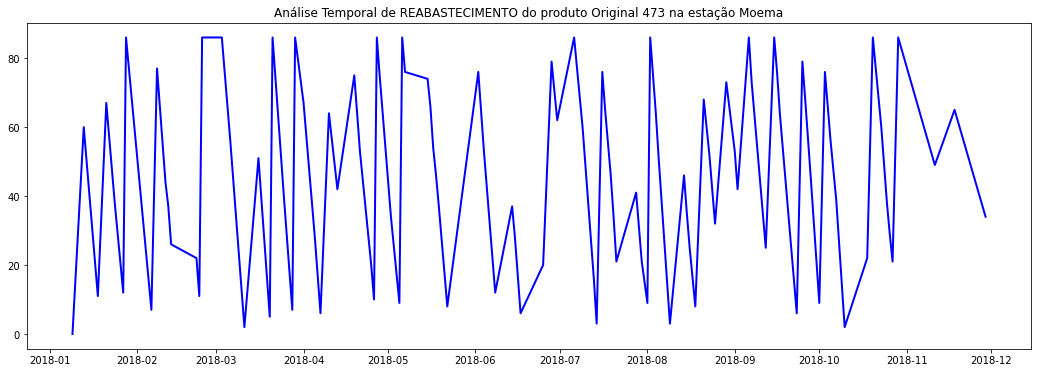

In [14]:
ts_moema = treino[treino['Estação'] == 'Moema'][['Tempo','Original_473','TARGET']].sort_values(by=['Tempo'])
ts_moema.dropna(inplace=True)
ts_moema = ts_moema.set_index('Tempo')
ts_moema = ts_moema[ts_moema['TARGET'] == 'REABASTECER']

# Plot da Série Temporal
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 6))
ax.plot(ts_moema.index, (ts_moema['Original_473']), alpha = 1, color ='b', ls = 'solid', linewidth=2)

# Evento: REABASTECIMENTO
#for i in range(0,ts_moema[ts_moema['TARGET'] == 'REABASTECER'].shape[0]):
#    ax.axvspan(*mdates.datestr2num([str(ts_moema.index[i]), str(ts_moema.index[i]+timedelta(days=1))]), color='gray', alpha=0.5)

ax.set_title('Análise Temporal de REABASTECIMENTO do produto Original 473 na estação Moema');

In [15]:
# Verificando a quantidade minima entre as latinhas por dia, que tinha na estacao Moema
tmp = treino[treino['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']].sort_values(by=['Tempo'])
tmp.dropna(inplace=True)
tmp = tmp.set_index('Tempo')
tmp.style.highlight_min(color = 'red', axis = 1) 

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
Tempo,,,,,,,,,
2018-01-01 00:00:00,86,65,65,43,43,43,43,43,NORMAL
2018-01-02 00:00:00,77,56,61,43,41,39,37,40,NORMAL
2018-01-03 00:00:00,64,47,56,42,37,33,34,36,NORMAL
2018-01-05 00:00:00,46,41,46,36,28,22,26,30,NORMAL
2018-01-06 00:00:00,37,33,37,31,24,18,23,28,NORMAL
2018-01-07 00:00:00,25,30,28,27,18,15,18,22,NORMAL
2018-01-08 00:00:00,13,23,24,27,13,11,14,19,NORMAL
2018-01-09 00:00:00,0,14,19,22,8,7,12,15,REABASTECER
2018-01-10 00:00:00,86,6,15,17,2,4,10,13,NORMAL


In [16]:
# Verificando a quantidade maxima entre as latinhas por dia, que tinha na estacao Moema
tmp = treino[treino['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']].sort_values(by=['Tempo'])
tmp.dropna(inplace=True)
tmp = tmp.set_index('Tempo')
tmp.style.highlight_max(color = 'lightgreen', axis = 1) 

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
Tempo,,,,,,,,,
2018-01-01 00:00:00,86,65,65,43,43,43,43,43,NORMAL
2018-01-02 00:00:00,77,56,61,43,41,39,37,40,NORMAL
2018-01-03 00:00:00,64,47,56,42,37,33,34,36,NORMAL
2018-01-05 00:00:00,46,41,46,36,28,22,26,30,NORMAL
2018-01-06 00:00:00,37,33,37,31,24,18,23,28,NORMAL
2018-01-07 00:00:00,25,30,28,27,18,15,18,22,NORMAL
2018-01-08 00:00:00,13,23,24,27,13,11,14,19,NORMAL
2018-01-09 00:00:00,0,14,19,22,8,7,12,15,REABASTECER
2018-01-10 00:00:00,86,6,15,17,2,4,10,13,NORMAL


# FAZENDO PREVISAO MANUALMENTE

In [17]:
# Aplicando formula manualmente considerando o volume maximo de cada latinha na estacao
def conditions2(data):
    if ((data['Original_473_diff'] < 0) or \
        (data['Original_269_diff'] < 0) or \
        (data['Zero_diff'] < 0) or \
        (data['Maçã-Verde_diff'] < 0) or \
        (data['Tangerina_diff'] < 0) or \
        (data['Citrus_diff'] < 0) or \
        (data['Açaí-Guaraná_diff'] < 0) or \
        (data['Pêssego_diff'] < 0)):

        return 'REABASTECER'
    
    else:
        return 'NORMAL'

In [18]:
# Percorrendo o dataset de treino e fazendo previsoes manualmente
# Verificando o % de acerto
for i in treino['Estação'].unique():

    tmp = treino[treino['Estação'] == i][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']].sort_values(by=['Tempo'])
    tmp.dropna(inplace=True)
    print('Estacao: '+ i)
    print(tmp['Tempo'].min())
    print(tmp['Tempo'].max())
    tmp = tmp.set_index('Tempo')

    tmp['Original_473_lag_1'] = tmp['Original_473'].shift(-1)
    tmp['Original_269_lag_1'] = tmp['Original_269'].shift(-1)
    tmp['Zero_lag_1']         = tmp['Zero'].shift(-1)
    tmp['Maçã-Verde_lag_1']   = tmp['Maçã-Verde'].shift(-1)
    tmp['Tangerina_lag_1']    = tmp['Tangerina'].shift(-1)
    tmp['Citrus_lag_1']       = tmp['Citrus'].shift(-1)
    tmp['Açaí-Guaraná_lag_1'] = tmp['Açaí-Guaraná'].shift(-1)
    tmp['Pêssego_lag_1']      = tmp['Pêssego'].shift(-1)

    tmp['Original_473_diff'] = tmp['Original_473'] - tmp['Original_473_lag_1']
    tmp['Original_269_diff'] = tmp['Original_269'] - tmp['Original_269_lag_1']
    tmp['Zero_diff']         = tmp['Zero'] - tmp['Zero_lag_1']
    tmp['Maçã-Verde_diff']   = tmp['Maçã-Verde'] - tmp['Maçã-Verde_lag_1']
    tmp['Tangerina_diff']    = tmp['Tangerina'] - tmp['Tangerina_lag_1']
    tmp['Citrus_diff']       = tmp['Citrus']- tmp['Citrus_lag_1']
    tmp['Açaí-Guaraná_diff'] = tmp['Açaí-Guaraná'] - tmp['Açaí-Guaraná_lag_1']
    tmp['Pêssego_diff']      = tmp['Pêssego'] - tmp['Pêssego_lag_1']

    tmp['TARGET_PRED'] = tmp.apply(conditions2, axis=1)

    tmp = tmp[['TARGET','TARGET_PRED']]

    tmp['ERROS'] = np.where(tmp['TARGET']==tmp['TARGET_PRED'], 0, 1)

    print('Acuracia: ' + str(round((1-(tmp['ERROS'].sum(axis=0)/tmp.shape[0]))*100,2)))
    print('\n')

Estacao: Luz
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 76.81


Estacao: Ana Rosa
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 77.17


Estacao: São Joaquim
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 77.38


Estacao: São Judas
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 77.4


Estacao: Vila Mariana
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 77.23


Estacao: Brooklin
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 77.86


Estacao: Campo Belo
2018-01-02 00:00:00
2019-12-30 00:00:00
Acuracia: 79.86


Estacao: Eucaliptos
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 76.63


Estacao: Moema
2018-01-01 00:00:00
2018-11-29 00:00:00
Acuracia: 78.37


Estacao: Paraíso
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 79.09


Estacao: Brigadeiro
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 77.64


Estacao: Trianon-Masp
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 79.31


Estacao: Consolação
2018-01-01 00:00:00
2019-12-30 00:00:00
Acuracia: 78.69


Es

In [19]:
# Verificando a data inicial e final das estacoes
# Hospital São Paulo
tmp = treino[treino['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp = tmp[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]

print('TREINO: Estacao: Moema')
print(tmp['Tempo'].min())
print(tmp['Tempo'].max())

print('\n')

tmp2 = teste[teste['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp2 = tmp2[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]

print('TESTE: Estacao: Moema')
print(tmp2['Tempo'].min())
print(tmp2['Tempo'].max())

TREINO: Estacao: Moema
2018-01-01 00:00:00
2018-11-29 00:00:00


TESTE: Estacao: Moema
2018-11-30 00:00:00
2019-12-30 00:00:00


In [20]:
# Verificando a data inicial e final das estacoes
# Hospital São Paulo
tmp = treino[treino['Estação'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp = tmp[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]

print('TREINO: Estacao: Hospital São Paulo')
print(tmp['Tempo'].min())
print(tmp['Tempo'].max())

print('\n')

tmp2 = teste[teste['Estação'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp2 = tmp2[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]

print('TESTE: Estacao: Hospital São Paulo')
print(tmp2['Tempo'].min())
print(tmp2['Tempo'].max())

TREINO: Estacao: Hospital São Paulo
2019-08-24 00:00:00
2019-12-30 00:00:00


TESTE: Estacao: Hospital São Paulo
2018-01-01 00:00:00
2019-08-23 00:00:00


# TREINANDO O MODELO PARA CADA ESTACAO

In [21]:
print('PREVISAO DA ESTACAO: Moema')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_moema = pd.concat([tmp_treino, tmp_teste])
df_moema = df_moema[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']]
df_moema = df_moema.set_index('Tempo')

df_moema['Original_473_lag_1'] = df_moema['Original_473'].shift(-1)
df_moema['Original_269_lag_1'] = df_moema['Original_269'].shift(-1)
df_moema['Zero_lag_1']         = df_moema['Zero'].shift(-1)
df_moema['Maçã-Verde_lag_1']   = df_moema['Maçã-Verde'].shift(-1)
df_moema['Tangerina_lag_1']    = df_moema['Tangerina'].shift(-1)
df_moema['Citrus_lag_1']       = df_moema['Citrus'].shift(-1)
df_moema['Açaí-Guaraná_lag_1'] = df_moema['Açaí-Guaraná'].shift(-1)
df_moema['Pêssego_lag_1']      = df_moema['Pêssego'].shift(-1)

df_moema['Original_473_diff'] = df_moema['Original_473'] - df_moema['Original_473_lag_1']
df_moema['Original_269_diff'] = df_moema['Original_269'] - df_moema['Original_269_lag_1']
df_moema['Zero_diff']         = df_moema['Zero'] - df_moema['Zero_lag_1']
df_moema['Maçã-Verde_diff']   = df_moema['Maçã-Verde'] - df_moema['Maçã-Verde_lag_1']
df_moema['Tangerina_diff']    = df_moema['Tangerina'] - df_moema['Tangerina_lag_1']
df_moema['Citrus_diff']       = df_moema['Citrus']- df_moema['Citrus_lag_1']
df_moema['Açaí-Guaraná_diff'] = df_moema['Açaí-Guaraná'] - df_moema['Açaí-Guaraná_lag_1']
df_moema['Pêssego_diff']      = df_moema['Pêssego'] - df_moema['Pêssego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_moema = df_moema.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maçã-Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Açaí-Guaraná_lag_1','Pêssego_lag_1'], axis = 1)
    
# Removendo todos os registros de teste    
df_moema.dropna(inplace=True)
df_moema = df_moema.reset_index()
print(df_moema.columns)

data_split = '2018-06-30'

X_train = df_moema[(df_moema['Tempo'] <= data_split)]
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','Tempo'], axis = 1)

X_valid = df_moema[(df_moema['Tempo'] > data_split)]
y_valid = X_valid['TARGET']
X_valid = X_valid.drop(['TARGET','Tempo'], axis = 1)

print('Dados Treino: ', X_train.shape)
print('Dados Validacao: ',X_valid.shape)

# Treinamento com XGB
model_xgb_moema = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb_moema.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))


PREVISAO DA ESTACAO: Moema
Index(['Tempo', 'Original_473', 'Original_269', 'Zero', 'Maçã-Verde',
       'Tangerina', 'Citrus', 'Açaí-Guaraná', 'Pêssego', 'TARGET',
       'Original_473_diff', 'Original_269_diff', 'Zero_diff',
       'Maçã-Verde_diff', 'Tangerina_diff', 'Citrus_diff', 'Açaí-Guaraná_diff',
       'Pêssego_diff'],
      dtype='object')
Dados Treino:  (172, 16)
Dados Validacao:  (147, 16)
              precision    recall  f1-score   support

      NORMAL       0.73      0.78      0.75        96
 REABASTECER       0.52      0.45      0.48        51

    accuracy                           0.67       147
   macro avg       0.63      0.62      0.62       147
weighted avg       0.66      0.67      0.66       147

F1_macro   :  0.6189896852684476
F1_micro   :  0.6666666666666666
F1_weighted:  0.6602486114784449


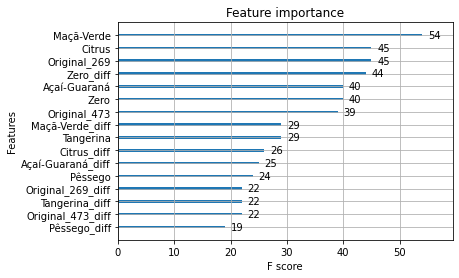

<Figure size 1296x2016 with 0 Axes>

In [22]:
xgb.plot_importance(model_xgb_moema)
plt.figure(figsize = (18, 28))
plt.show()

In [23]:
print('PREVISAO DA ESTACAO: Hospital São Paulo')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estação'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estação'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_hsp = pd.concat([tmp_teste, tmp_treino])
df_hsp = df_hsp[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']]
df_hsp = df_hsp.set_index('Tempo')

df_hsp['Original_473_lag_1'] = df_hsp['Original_473'].shift(-1)
df_hsp['Original_269_lag_1'] = df_hsp['Original_269'].shift(-1)
df_hsp['Zero_lag_1']         = df_hsp['Zero'].shift(-1)
df_hsp['Maçã-Verde_lag_1']   = df_hsp['Maçã-Verde'].shift(-1)
df_hsp['Tangerina_lag_1']    = df_hsp['Tangerina'].shift(-1)
df_hsp['Citrus_lag_1']       = df_hsp['Citrus'].shift(-1)
df_hsp['Açaí-Guaraná_lag_1'] = df_hsp['Açaí-Guaraná'].shift(-1)
df_hsp['Pêssego_lag_1']      = df_hsp['Pêssego'].shift(-1)

df_hsp['Original_473_diff'] = df_hsp['Original_473'] - df_hsp['Original_473_lag_1']
df_hsp['Original_269_diff'] = df_hsp['Original_269'] - df_hsp['Original_269_lag_1']
df_hsp['Zero_diff']         = df_hsp['Zero'] - df_hsp['Zero_lag_1']
df_hsp['Maçã-Verde_diff']   = df_hsp['Maçã-Verde'] - df_hsp['Maçã-Verde_lag_1']
df_hsp['Tangerina_diff']    = df_hsp['Tangerina'] - df_hsp['Tangerina_lag_1']
df_hsp['Citrus_diff']       = df_hsp['Citrus']- df_hsp['Citrus_lag_1']
df_hsp['Açaí-Guaraná_diff'] = df_hsp['Açaí-Guaraná'] - df_hsp['Açaí-Guaraná_lag_1']
df_hsp['Pêssego_diff']      = df_hsp['Pêssego'] - df_hsp['Pêssego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_hsp = df_hsp.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maçã-Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Açaí-Guaraná_lag_1','Pêssego_lag_1'], axis = 1)
    
# Removendo todos os registros de teste    
df_hsp.dropna(inplace=True)
df_hsp = df_hsp.reset_index()

data_split = '2019-10-30'

X_train = df_hsp[(df_hsp['Tempo'] <= data_split)]
y_train = X_train['TARGET']
X_train = X_train.drop(['TARGET','Tempo'], axis = 1)

X_valid = df_hsp[(df_hsp['Tempo'] > data_split)]
y_valid = X_valid['TARGET']
X_valid = X_valid.drop(['TARGET','Tempo'], axis = 1)

print('Dados Treino: ', X_train.shape)
print('Dados Validacao: ',X_valid.shape)

# Treinamento com XGB
model_xgb_hsp = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb_hsp.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))


PREVISAO DA ESTACAO: Hospital São Paulo
Dados Treino:  (66, 16)
Dados Validacao:  (59, 16)
              precision    recall  f1-score   support

      NORMAL       0.70      0.90      0.79        39
 REABASTECER       0.56      0.25      0.34        20

    accuracy                           0.68        59
   macro avg       0.63      0.57      0.57        59
weighted avg       0.65      0.68      0.64        59

F1_macro   :  0.5656722200697404
F1_micro   :  0.6779661016949152
F1_weighted:  0.6367916784323511


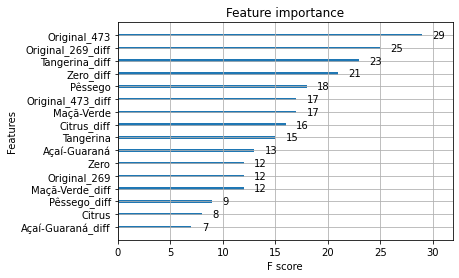

<Figure size 1296x2016 with 0 Axes>

In [24]:
xgb.plot_importance(model_xgb_hsp)
plt.figure(figsize = (18, 28))
plt.show()

# FAZENDO PREVISOES

In [25]:
print('PREVISAO DA ESTACAO: Moema')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estação'] == 'Moema'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_moema = pd.concat([tmp_treino, tmp_teste])

# Apenas dados de teste 
df_moema = df_moema[df_moema['dataset'] == 'TESTE']
df_moema = df_moema[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]
df_moema = df_moema.set_index('Tempo')

df_moema['Original_473_lag_1'] = df_moema['Original_473'].shift(-1)
df_moema['Original_269_lag_1'] = df_moema['Original_269'].shift(-1)
df_moema['Zero_lag_1']         = df_moema['Zero'].shift(-1)
df_moema['Maçã-Verde_lag_1']   = df_moema['Maçã-Verde'].shift(-1)
df_moema['Tangerina_lag_1']    = df_moema['Tangerina'].shift(-1)
df_moema['Citrus_lag_1']       = df_moema['Citrus'].shift(-1)
df_moema['Açaí-Guaraná_lag_1'] = df_moema['Açaí-Guaraná'].shift(-1)
df_moema['Pêssego_lag_1']      = df_moema['Pêssego'].shift(-1)

df_moema['Original_473_diff'] = df_moema['Original_473'] - df_moema['Original_473_lag_1']
df_moema['Original_269_diff'] = df_moema['Original_269'] - df_moema['Original_269_lag_1']
df_moema['Zero_diff']         = df_moema['Zero'] - df_moema['Zero_lag_1']
df_moema['Maçã-Verde_diff']   = df_moema['Maçã-Verde'] - df_moema['Maçã-Verde_lag_1']
df_moema['Tangerina_diff']    = df_moema['Tangerina'] - df_moema['Tangerina_lag_1']
df_moema['Citrus_diff']       = df_moema['Citrus']- df_moema['Citrus_lag_1']
df_moema['Açaí-Guaraná_diff'] = df_moema['Açaí-Guaraná'] - df_moema['Açaí-Guaraná_lag_1']
df_moema['Pêssego_diff']      = df_moema['Pêssego'] - df_moema['Pêssego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_moema = df_moema.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maçã-Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Açaí-Guaraná_lag_1','Pêssego_lag_1'], axis = 1)
df_moema = df_moema.reset_index()

X_teste = df_moema.drop(['Tempo'], axis = 1)

# Validacao do modelo
y_pred_teste = model_xgb_moema.predict(X_teste)


df_moema['TARGET_MODELO'] = y_pred_teste
df_moema['TARGET_RODRIGO'] = df_moema.apply(conditions2, axis=1)


df_moema = df_moema[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET_MODELO','TARGET_RODRIGO']]
df_moema

PREVISAO DA ESTACAO: Moema


,Tempo,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET_MODELO,TARGET_RODRIGO
0,2018-11-30 00:00:00,22,65,22,14,3,26,43,18,NORMAL,REABASTECER
1,2018-12-01 00:00:00,11,56,16,14,43,20,37,15,REABASTECER,REABASTECER
2,2018-12-02 00:00:00,86,51,8,11,41,20,35,12,NORMAL,REABASTECER
3,2018-12-03 00:00:00,76,47,65,11,37,14,32,10,NORMAL,NORMAL
4,2018-12-04 00:00:00,68,42,60,6,35,13,26,5,NORMAL,REABASTECER
5,2018-12-05 00:00:00,57,35,55,43,31,9,22,43,NORMAL,NORMAL
6,2018-12-06 00:00:00,45,33,50,39,25,5,16,39,NORMAL,REABASTECER
7,2018-12-07 00:00:00,34,28,41,39,22,43,13,34,NORMAL,NORMAL
8,2018-12-08 00:00:00,22,24,31,35,18,40,8,29,NORMAL,NORMAL
9,2018-12-09 00:00:00,9,16,26,33,13,38,4,24,REABASTECER,REABASTECER


In [26]:
print('PREVISAO DA ESTACAO: Hospital São Paulo')

# Concatenando as bases de dados de treino e teste do Hospital São Paulo
tmp_treino = treino[treino['Estação'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']].sort_values(by=['Tempo'])
tmp_treino = tmp_treino[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET']]
tmp_treino = tmp_treino.dropna(axis='index', how='any', subset=['Tempo'])
tmp_treino['dataset'] = 'TREINO'

tmp_teste = teste[teste['Estação'] == 'Hospital São Paulo'][['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']].sort_values(by=['Tempo'])
tmp_teste = tmp_teste[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]
tmp_teste = tmp_teste.dropna(axis='index', how='any', subset=['Tempo'])
tmp_teste['dataset'] = 'TESTE'

# Concatenar na ordem da data: primeiro treino depois teste
df_hsp = pd.concat([tmp_teste, tmp_treino])

# Apenas dados de teste 
df_hsp = df_hsp[df_hsp['dataset'] == 'TESTE']
df_hsp = df_hsp[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego']]
df_hsp = df_hsp.set_index('Tempo')

df_hsp['Original_473_lag_1'] = df_hsp['Original_473'].shift(-1)
df_hsp['Original_269_lag_1'] = df_hsp['Original_269'].shift(-1)
df_hsp['Zero_lag_1']         = df_hsp['Zero'].shift(-1)
df_hsp['Maçã-Verde_lag_1']   = df_hsp['Maçã-Verde'].shift(-1)
df_hsp['Tangerina_lag_1']    = df_hsp['Tangerina'].shift(-1)
df_hsp['Citrus_lag_1']       = df_hsp['Citrus'].shift(-1)
df_hsp['Açaí-Guaraná_lag_1'] = df_hsp['Açaí-Guaraná'].shift(-1)
df_hsp['Pêssego_lag_1']      = df_hsp['Pêssego'].shift(-1)

df_hsp['Original_473_diff'] = df_hsp['Original_473'] - df_hsp['Original_473_lag_1']
df_hsp['Original_269_diff'] = df_hsp['Original_269'] - df_hsp['Original_269_lag_1']
df_hsp['Zero_diff']         = df_hsp['Zero'] - df_hsp['Zero_lag_1']
df_hsp['Maçã-Verde_diff']   = df_hsp['Maçã-Verde'] - df_hsp['Maçã-Verde_lag_1']
df_hsp['Tangerina_diff']    = df_hsp['Tangerina'] - df_hsp['Tangerina_lag_1']
df_hsp['Citrus_diff']       = df_hsp['Citrus']- df_hsp['Citrus_lag_1']
df_hsp['Açaí-Guaraná_diff'] = df_hsp['Açaí-Guaraná'] - df_hsp['Açaí-Guaraná_lag_1']
df_hsp['Pêssego_diff']      = df_hsp['Pêssego'] - df_hsp['Pêssego_lag_1']

# Removendo coluna LAG pois foi somente para calcular a diferenca
df_hsp = df_hsp.drop(['Original_473_lag_1','Original_269_lag_1','Zero_lag_1','Maçã-Verde_lag_1','Tangerina_lag_1','Citrus_lag_1','Açaí-Guaraná_lag_1','Pêssego_lag_1'], axis = 1)
df_hsp = df_hsp.reset_index()

X_teste = df_hsp.drop(['Tempo'], axis = 1)

# Validacao do modelo
y_pred_teste = model_xgb_hsp.predict(X_teste)


df_hsp['TARGET_MODELO'] = y_pred_teste
df_hsp['TARGET_RODRIGO'] = df_hsp.apply(conditions2, axis=1)


df_hsp = df_hsp[['Tempo','Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET_MODELO','TARGET_RODRIGO']]
df_hsp

PREVISAO DA ESTACAO: Hospital São Paulo


,Tempo,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET_MODELO,TARGET_RODRIGO
0,2018-01-01 00:00:00,86,65,65,43,43,43,43,43,NORMAL,NORMAL
1,2018-01-02 00:00:00,73,58,61,42,40,40,40,38,NORMAL,NORMAL
2,2018-01-03 00:00:00,62,53,54,38,37,37,38,35,NORMAL,NORMAL
3,2018-01-04 00:00:00,52,50,50,33,33,33,32,32,NORMAL,NORMAL
4,2018-01-05 00:00:00,44,45,46,32,30,29,30,29,NORMAL,NORMAL
5,2018-01-06 00:00:00,34,43,37,30,26,27,24,24,NORMAL,NORMAL
6,2018-01-07 00:00:00,26,34,28,26,22,21,20,18,NORMAL,NORMAL
7,2018-01-08 00:00:00,14,27,18,20,19,19,17,16,NORMAL,NORMAL
8,2018-01-09 00:00:00,6,17,13,15,15,13,15,12,NORMAL,REABASTECER
9,2018-01-10 00:00:00,86,8,5,14,9,11,9,8,NORMAL,REABASTECER


# RESULTADO FINAL COM A PREVISAO DO MODELO

In [27]:
df_final = pd.concat([df_moema, df_hsp])
df_final = df_final[['Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET_MODELO']]
df_final = df_final.rename(columns={"TARGET_MODELO": "TARGET"})

# Gravando resultado em csv
df_final.to_csv('Desafio-7-results/results_modelo.csv',index=False)
print(df_final.shape)

(984, 9)


# RESULTADO FINAL COM A PREVISAO DO RODRIGO (NA MAO)

In [28]:
df_final = pd.concat([df_moema, df_hsp])
df_final = df_final[['Original_473','Original_269','Zero','Maçã-Verde','Tangerina','Citrus','Açaí-Guaraná','Pêssego','TARGET_RODRIGO']]
df_final = df_final.rename(columns={"TARGET_RODRIGO": "TARGET"})

# Gravando resultado em csv
df_final.to_csv('Desafio-7-results/results_rodrigo.csv',index=False)
print(df_final.shape)

(984, 9)


# BACKUP DE CODIGO

In [29]:
#tmp = tmp.reset_index(drop=True)
#tmp['qtde_total_dia'] = tmp.sum(axis=1)
#tmp['qtde_min_dia'] = tmp.min(axis=1)
#tmp['qtde_max_dia'] = tmp.max(axis=1)
#tmp['qtde_mean_dia'] = tmp.mean(axis=1)
#tmp['capacidade_total_estacao'] = tmp['qtde_max_dia'].max(axis=0)
#tmp['perc_abaixo_capacidade_total'] = tmp['qtde_min_dia'] / tmp['capacidade_total_estacao'] * 100
#tmp['perc_abaixo_qtde_dia'] = tmp['qtde_max_dia'] / tmp['capacidade_total_estacao'] * 100
#tmp = tmp[['Tempo','TARGET','qtde_min_dia','qtde_max_dia','qtde_mean_dia','capacidade_total_estacao','perc_abaixo_capacidade_total','perc_abaixo_qtde_dia']]